## Installation 

In [1]:

# pip install seaborn 
# and others if not already installed...

In [2]:
import os

import cv2

import matplotlib.pylab as plt

# data augmentation
from PIL import Image
from PIL import ImageOps
from PIL import ImageFilter

# Split arrays or matrices into random train and test subsets
from sklearn.model_selection import train_test_split

# remove if not needed because augmentation is already applied 
from sklearn.utils.class_weight import compute_class_weight

import re

import random

import time
import copy

import pandas as pd

import numpy as np

import seaborn as sns
sns.set()

In [3]:
from os import listdir
from glob import glob

## Structure of the original data

In [4]:
patients = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/')
noPatients = len(patients)  # 279 patients in total -> not a lot -> overfitting likely
print("Number of total patients in data set: " + str(noPatients))
print("sample patient ids: " + str(patients[190:200]))  # patients have 4-to-5-digit ids

Number of total patients in data set: 279
sample patient ids: ['12897', '9173', '9041', '10288', '12748', '8864', '12868', '13459', '16896', '9078']


In [5]:
twoClasses = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864')
print(twoClasses)
print("--> 2 folders per patient: one for benign (0), the other for malign patches(1)")

['0', '1']
--> 2 folders per patient: one for benign (0), the other for malign patches(1)


In [6]:
imgFileNames0 = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864/0')[:3]
print("sample image names for class 0: \n" + str(imgFileNames0))
print()
imgFileNames1 = listdir('data/breast-histopathology-images/IDC_regular_ps50_idx5/8864/1')[:3]
print("sample image names for class 1: \n" + str(imgFileNames1))

sample image names for class 0: 
['8864_idx5_x2701_y2401_class0.png', '8864_idx5_x2751_y2451_class0.png', '8864_idx5_x2151_y1001_class0.png']

sample image names for class 1: 
['8864_idx5_x1851_y2051_class1.png', '8864_idx5_x1651_y2701_class1.png', '8864_idx5_x2351_y2651_class1.png']


In [7]:
allImagePatches = glob('data/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
print("sample full paths to images: ")
for filename in allImagePatches[150000:150005]:
    print(filename)

sample full paths to images: 
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1001_y351_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x751_y201_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1701_y851_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1451_y501_class1.png
data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x951_y851_class1.png


In [8]:
noAllPatches = len(allImagePatches)
print("total number of original images: " + str(noAllPatches))  # 277524

total number of original images: 277524


## Data visualisation

In [9]:
# read in 2 randomly selected example image patches
image_class0 = cv2.imread('data/breast-histopathology-images/IDC_regular_ps50_idx5/12905/0/12905_idx5_x1201_y2301_class0.png')
image_class1 = cv2.imread('data/breast-histopathology-images/IDC_regular_ps50_idx5/14304/1/14304_idx5_x1701_y851_class1.png')

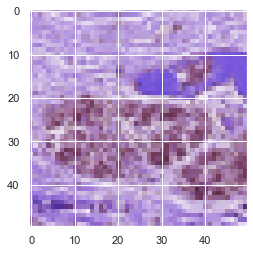

In [10]:
# show patch from class 0
plt.imshow(image_class0)

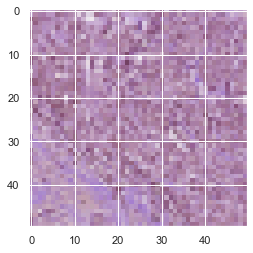

In [11]:
# show patch from class 1
plt.imshow(image_class1)

### Try different colour modes

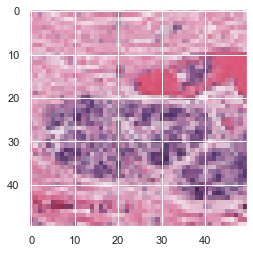

In [12]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2RGB))

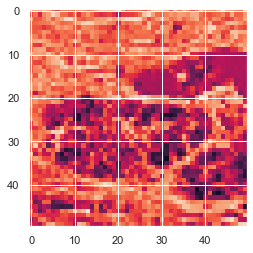

In [13]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2GRAY))

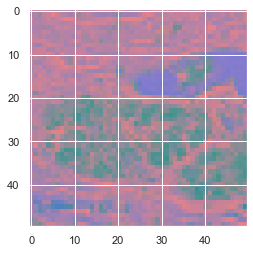

In [14]:
# color scheme used in paper
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_BGR2YUV))

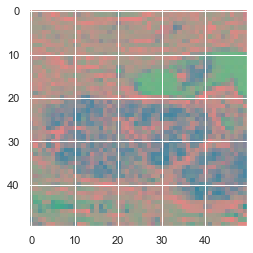

In [15]:
plt.imshow(cv2.cvtColor(image_class0, cv2.COLOR_RGB2YUV))

### Plot 64 tissue patches from both classes (randomly selected)

In [16]:
def plotTissuePatches(imagesForPlot):
    i_ = 0
    plt.rcParams['figure.figsize'] = (16.0, 16.0)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    random.shuffle(imagesForPlot)
    for image in imagesForPlot[8459:8523]:
        title = ""
        if "class0" in image:
            title = "0"
        else:
            title = "1"
        im = cv2.imread(image)   
        plt.subplot(8, 8, i_+1).set_title(title)
        plt.imshow(im); plt.axis('off')
        i_ += 1

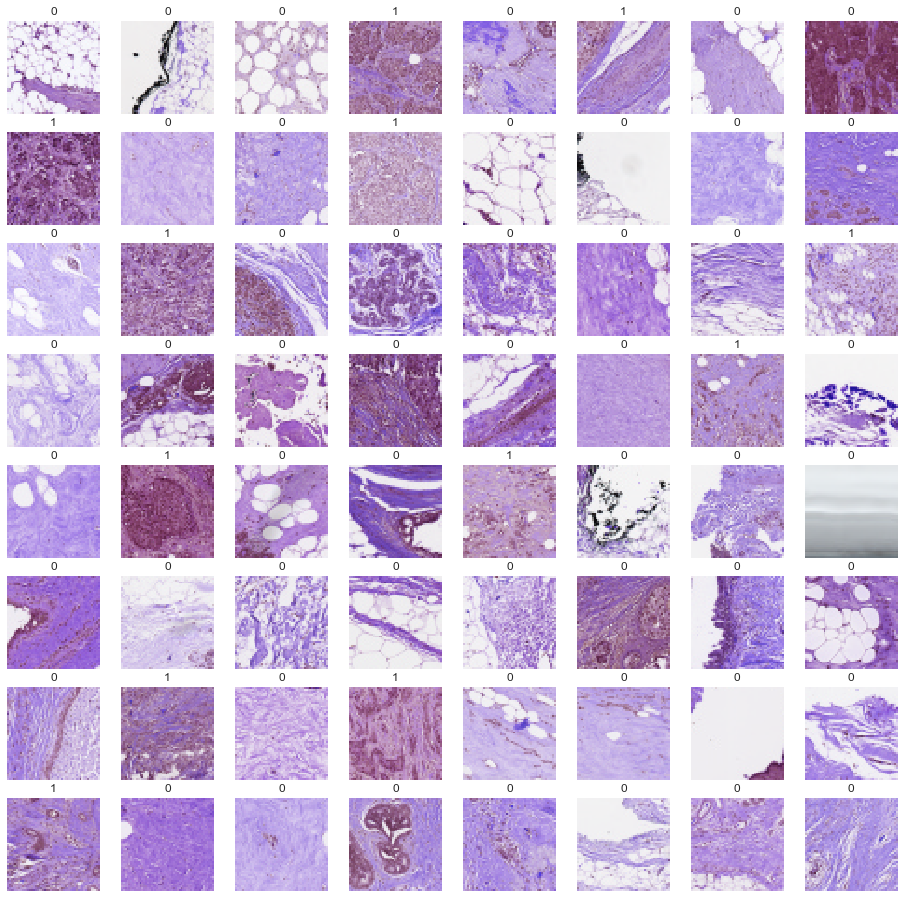

In [17]:
plotTissuePatches(allImagePatches)

## Create data frame

#### <font color='red'>Skip next 3 cells and continue at "Load data frame here"!</font>

In [51]:
# create empty data frame
data = pd.DataFrame(index=np.arange(0, noAllPatches), columns=["patient_id", "image_path", "label"])

# define base path
basePath = "data/breast-histopathology-images/IDC_regular_ps50_idx5/"

# fill data frame
def fillDataFrame(df, path, patients):
    i = 0
    for j in range(len(patients)):
        patientId = patients[j]
        patientPath = path + str(patientId)
        for label in [0,1]:
            classPath = patientPath + "/" + str(label) + "/"
            subfiles = listdir(classPath)
            for k in range(len(subfiles)):
                imagePath = subfiles[k]
                df.iloc[i]["image_path"] = classPath + imagePath
                df.iloc[i]["label"] = label
                df.iloc[i]["patient_id"] = patientId
                i += 1  
                
    return df

In [52]:
data = fillDataFrame(data, basePath, patients)
data

,patient_id,image_path,label
0,12905,data/breast-histopathology-images/IDC_regular_...,0
1,12905,data/breast-histopathology-images/IDC_regular_...,0
2,12905,data/breast-histopathology-images/IDC_regular_...,0
3,12905,data/breast-histopathology-images/IDC_regular_...,0
4,12905,data/breast-histopathology-images/IDC_regular_...,0
...,...,...,...
277519,9135,data/breast-histopathology-images/IDC_regular_...,1
277520,9135,data/breast-histopathology-images/IDC_regular_...,1
277521,9135,data/breast-histopathology-images/IDC_regular_...,1
277522,9135,data/breast-histopathology-images/IDC_regular_...,1


In [69]:
# Save data frame to json
data.to_json("dataframes/dfWithPatientPathLabel.json")

#### <font color='red'>Continue here...</font>

#### Load data frame here:

In [19]:
# Load data frame from json
loaded_df = pd.read_json("dataframes/dfWithPatientPathLabel.json")

In [20]:
# Print shape of loaded data frame
loaded_df.shape # should be (277524, 3)

(277524, 3)

## Analyse data set

#### Plot statistics on data set

In [21]:
def plotStatistics(df): 
    
    fig, ax = plt.subplots(1,3,figsize=(24,6))

    # Number of patches per patient
    sns.distplot(df.groupby("patient_id").size(), ax=ax[0], color="Black", kde=False, bins=30)
    ax[0].set_xlabel("Number of patches")
    ax[0].set_ylabel("Absolute frequency");
    ax[0].set_title("Number of patches per patient");

    # Percentage of malign patches
    cancer_perc = df.groupby("patient_id").label.value_counts(1)
    sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Red", kde=False, bins=30)
    ax[1].set_title("How much of a tissue sample is diagnosed malign?")
    ax[1].set_ylabel("Absolute frequency")
    ax[1].set_xlabel("% of patches malign");

    # Total number of benign and malign patches
    sns.countplot(df.label, ax=ax[2]);
    ax[2].set_xlabel("benign (class 0) vs. malign (class 1)")
    ax[2].set_title("How many patches are labeled malign in total?");

    print()

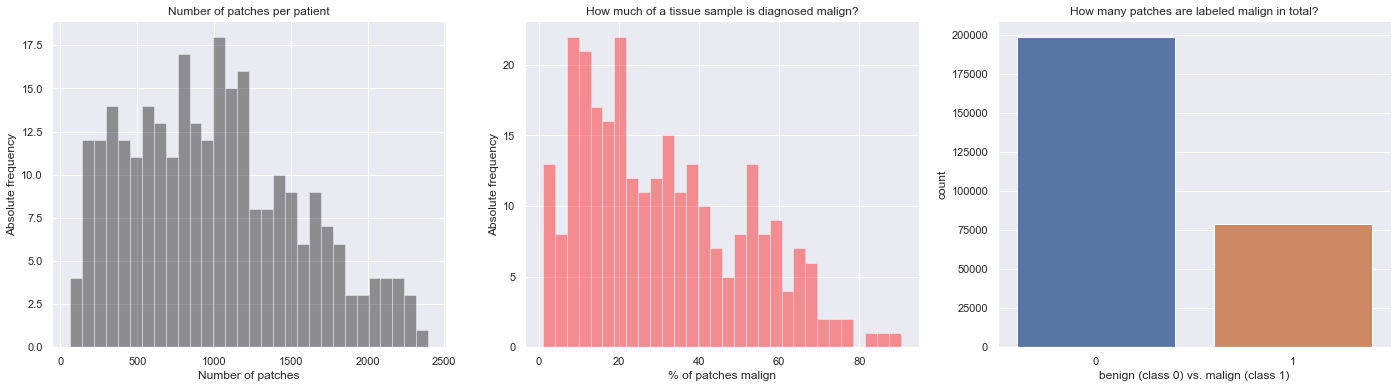

In [22]:
plotStatistics(loaded_df)

### Reconstruction of tissue samples as a whole

#### Extract coordinates from image patches 

In [23]:
# extract x and y coordinates of each patch in tissue sample images and append to df
def extractCoords(df):
    coord = df.image_path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df # TODO: Vorsicht: manipuliert übergebenen df. Besser!?: neuen df erzeugen

In [25]:
dfWithCoords = extractCoords(loaded_df)

In [37]:
# get df per patient
def getPatientDf(patient, coord_df):
    patient_df = coord_df.loc[coord_df["patient_id"] == patient]
    return patient_df

In [38]:
# Plot randomly selected tissues from different patients
def plotSampleTissues(no_rows, no_cols, df):
    patients = list(loaded_df.patient_id.unique())
    no_patient_plots = no_rows * no_cols
    patients = random.sample(patients, k=no_patient_plots)
    fig, ax = plt.subplots(no_rows, no_cols, figsize=(20, 25))
    for i in range(no_rows):
        for j in range(no_cols):
            patient_id = patients[j + no_cols*i]
            patient_df = getPatientDf(patient_id, df)

            ax[i,j].scatter(patient_df.x.values, patient_df.y.values, c=patient_df.label.values, cmap="coolwarm", s=20);
            ax[i,j].set_title("patient " + str(patient_id))
            ax[i,j].set_xlabel("x")
            ax[i,j].set_ylabel("y")

#### Plot 15 sample tissues of randomly selected patients, marked by diagnosed class (0: blue, 1: red)

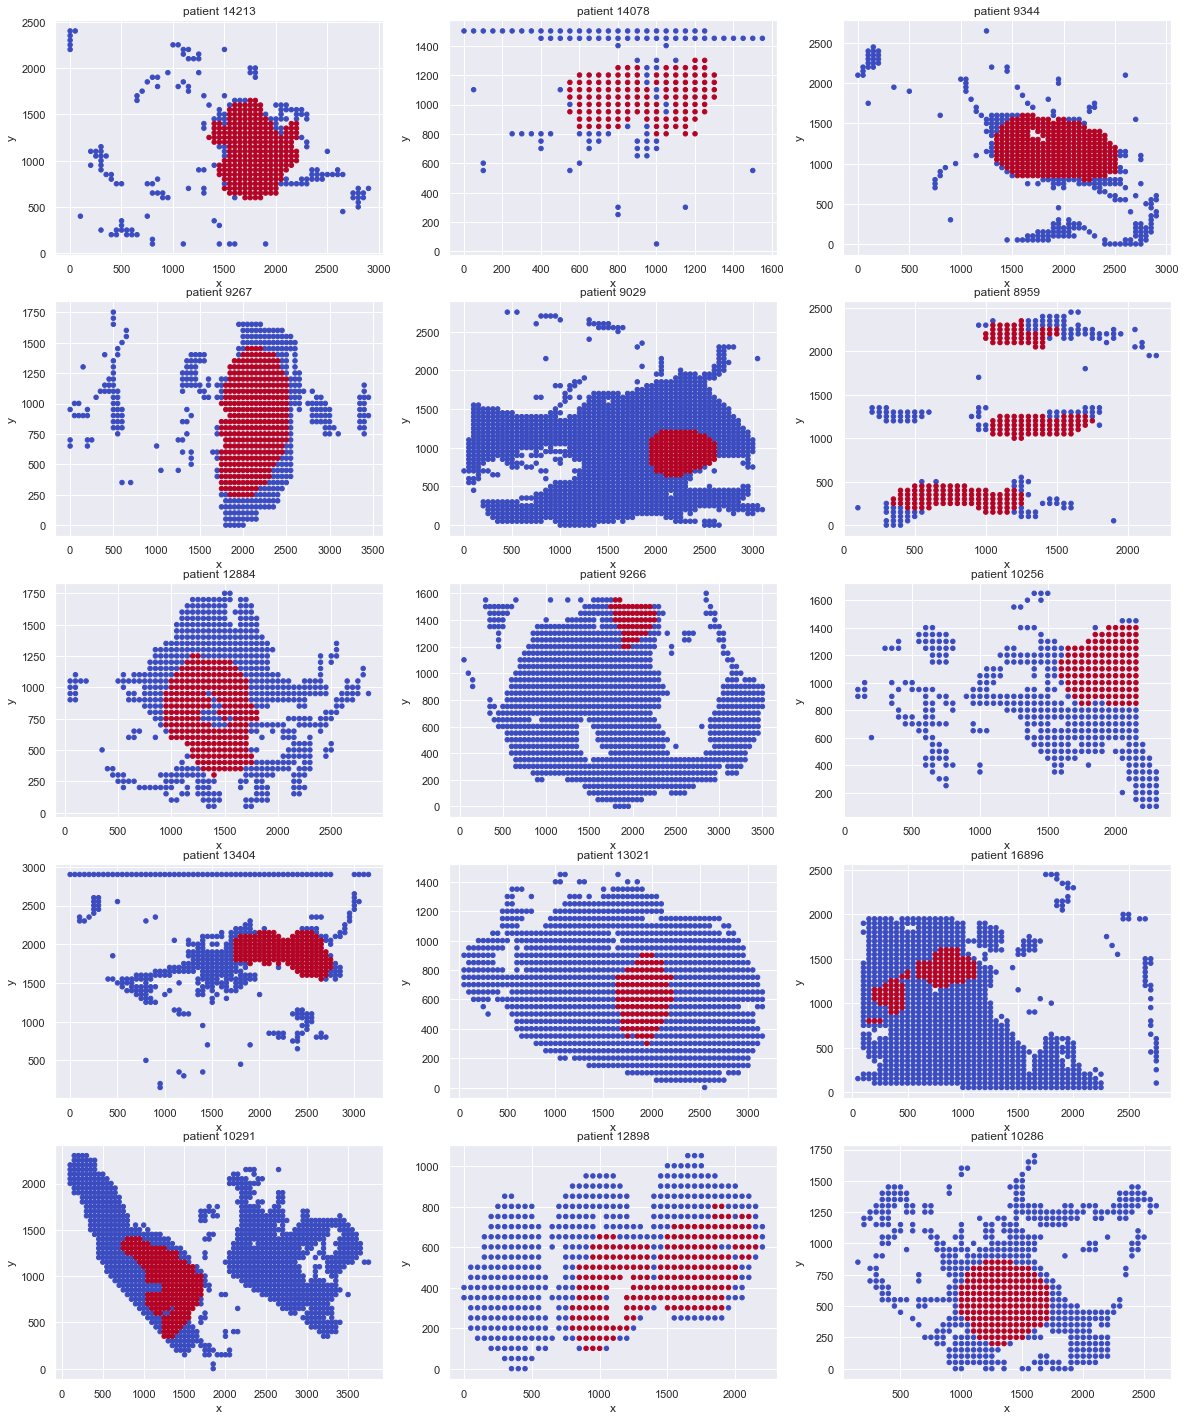

In [39]:
plotSampleTissues(5,3,dfWithCoords)

TODO: explain gaps in tissue information

## The imbalanced class problem

In [55]:
size_class0 = len(loaded_df[loaded_df['label'] == 0]) #198.738
size_class1 = len(loaded_df[loaded_df['label'] == 1]) #78.786 

print(str(size_class0) + " images belong to class 0, while class 1 has a size of just " + str(size_class1))
print("--> difference of " + str(size_class0 - size_class1) + " between the two classes")
print("--> class 0 is ~ " + str("{0:.2f}".format(size_class0/size_class1)) + " times larger than class 1")

198738 images belong to class 0, while class 1 has a size of just 78786
--> difference of 119952 between the two classes
--> class 0 is ~ 2.52 times larger than class 1


# Data split
    
Split must be done on patient level ("Note that in medical imaging datasets, the split should always been [sic] done patient-level, meaning images of the same patient should either belong to the train or test set but not be shared among them." (https://mc.ai/skin-cancer-image-classification%E2%80%8A-%E2%80%8Aan-educational-guide/))

#### Number of patches per patient
--> varying number of patches has to be ignored

In [51]:
# show number of patches per patient
loaded_df.groupby("patient_id")["patient_id"].count()

patient_id
8863      979
8864     1133
8865      712
8867     1642
8913      955
         ... 
16568     828
16569     337
16570     917
16895     151
16896    1127
Name: patient_id, Length: 279, dtype: int64

### Split into training, validation and test sets:
- Training: ~ 72 % = 200 patients
- Validation: ~ 14 % = 39 patients
- Test: ~ 14 % = 40 patients
------------------------------
- Number of patients in total: 279

#### Subdivide patients by their ids

In [67]:
#take unique patient_ids to split data patient-wise
patients = loaded_df.patient_id.unique()

#split patient_ids into training and test data:
train_ids, test_ids = train_test_split(patients, test_size=0.14, random_state=0)

#split training into train and validation sets:
final_train_ids, val_ids = train_test_split(train_ids, test_size=0.16, random_state=0)

print("Number of patients for training set: " + str(len(final_train_ids)))
print("Number of patients for validation set: " + str(len(val_ids)))
print("Number of patients for test set: " + str(len(test_ids)))

Number of patients for training set: 200
Number of patients for validation set: 39
Number of patients for test set: 40


In [60]:
# show patients selected for validation set
print("patients in validation set: " + str(val_ids))

patients in validation set: [16533 15515  9178 13694 15514 12907  9081 12868  9181 13021 13404 14188
 10277 10264 10274  8974  9176 12876 12824 10286 13617 15516 16550 15510
  9126 10259  9255 16167 10295 12873  8950  9262 13691 10290  9076 10256
 13023 12910 15473]


#### Create data frames from selected patients for training, test and validation set respectively

In [63]:
#new training set:
train_df = loaded_df.loc[loaded_df.patient_id.isin(final_train_ids),:].copy()

#new test set:
test_df = loaded_df.loc[loaded_df.patient_id.isin(test_ids),:].copy()

#new validation set:
val_df = loaded_df.loc[loaded_df.patient_id.isin(val_ids),:].copy()

In [64]:
#check whether train_df contains correct number of patients
len(train_df.groupby("patient_id")["patient_id"].count()) # should be 200

200

#### Check class distribution in newly divided datasets

Text(0, 0.5, 'number of patients')

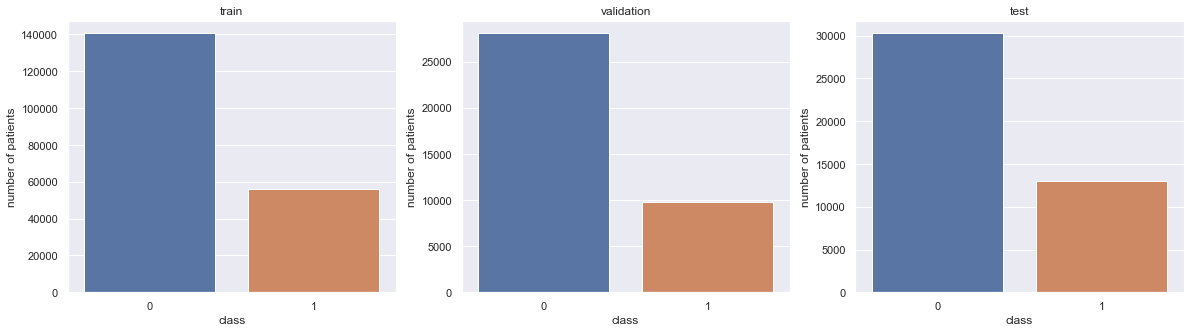

In [66]:
# plot class distribution..
fig, ax = plt.subplots(1,3,figsize=(20,5))

# .. for training set
sns.countplot(train_df.label, ax=ax[0])
ax[0].set_title("train")
ax[0].set_xlabel("class")
ax[0].set_ylabel("number of patients")

# .. for validation set
sns.countplot(val_df.label, ax=ax[1])
ax[1].set_title("validation")
ax[1].set_xlabel("class")
ax[1].set_ylabel("number of patients")

# .. for test set
sns.countplot(test_df.label, ax=ax[2])
ax[2].set_title("test")
ax[2].set_xlabel("class")
ax[2].set_ylabel("number of patients")

In [77]:
#class distribution in training set:
train_class0 = len(train_df[train_df['label'] == 0]) #140.416
train_class1 = len(train_df[train_df['label'] == 1]) #55.909

print("Class distribution in training set:")
print("class0: " + str(train_class0))
print("class1: " + str(train_class1))
print("--> ratio (class0:class1) ~ " + str("{0:.2f}".format(train_class0/train_class1)))

Class distribution in training set:
class0: 140416
class1: 55909
--> ratio (class0:class1) ~ 2.51


In [78]:
#class distribution in validation set:
val_class0 = len(val_df[val_df['label'] == 0]) #28.057
val_class1 = len(val_df[val_df['label'] == 1]) #9.829

print("Class distribution in validation set:")
print("class0: " + str(val_class0))
print("class1: " + str(val_class1))
print("--> ratio (class0:class1) ~ " + str("{0:.2f}".format(val_class0/val_class1)))

Class distribution in validation set:
class0: 28057
class1: 9829
--> ratio (class0:class1) ~ 2.85


In [79]:
#class distribution in test set:
test_class0 = len(test_df[test_df['label'] == 0]) #30.265
test_class1 = len(test_df[test_df['label'] == 1]) #13.048

print("Class distribution in test set:")
print("class0: " + str(test_class0))
print("class1: " + str(test_class1))
print("--> ratio (class0:class1) ~ " + str("{0:.2f}".format(test_class0/test_class1)))

Class distribution in test set:
class0: 30265
class1: 13048
--> ratio (class0:class1) ~ 2.32


## Data augmentation

In the following section we will use data augmentation on the training set to boost the number of image patches with class 1 as it is much smaller than class 0. The aim is to augment the data of class 1 (malign), the minority class, until it reaches the size of majority class 0. 

In the first section we will do some "manual" augmentation and visualize the results to get an idea of what is happening. We will perform image rotation and flipping for an original image patch.


In [40]:
#example patch:
imagePath_for_Aug = loaded_df.loc[0]['image_path']
imageClass = loaded_df.loc[0]['label']

In [41]:
#TO DO: In the research paper they use 'YUV' as color_mode. Leads to problems with cv2.imread as
# it needs RGB/ BGR as color mode apparently (error, no visulaization possible)
# But does it make more sense to use YUV?

#note: resizing the patch is not necessary (50x50 good choice already)
def preprocess_patch(image_path, color_mode):
    patch = cv2.imread(image_path)
    img_as_arr = Image.fromarray(patch, color_mode) #color_mode kann auch weggelassen werden; YUV nehmen??
    return img_as_arr  

In [42]:
#rotate and mirror a single image patch:
#this function also adds labels so the original image and the augmented onces can be visualized with labels
def augment_patch(image):
    augmented_images = []
    aug_labels = []
    
    #add original patch first for visualization purpose?
    augmented_images.append(image)
    aug_labels.append('original')
    
    #rotate original patch:
    rotation_angles = [90, 180, 270]
    for angle in rotation_angles:
        rotated_img = image.rotate(angle)
        augmented_images.append(rotated_img)
        aug_labels.append(angle)

    #mirror the patch:
    mirrored_img = ImageOps.mirror(image)
    augmented_images.append(mirrored_img)
    aug_labels.append('mirrored')
    
    return augmented_images, aug_labels    

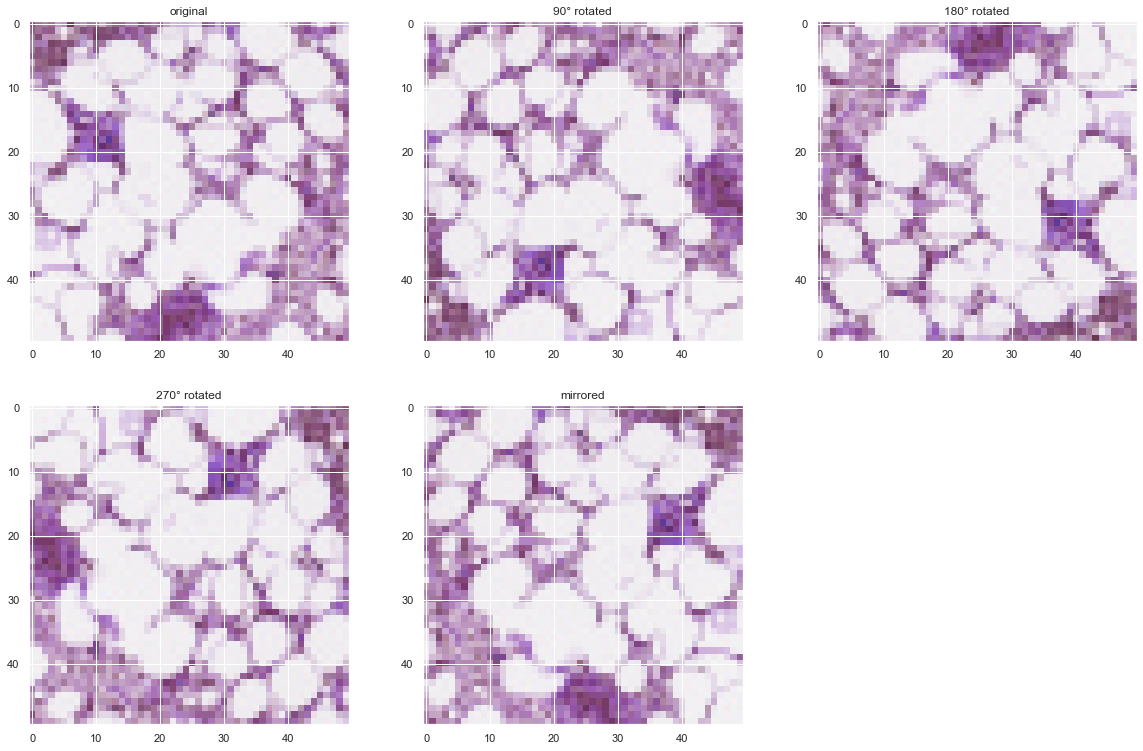

In [37]:
#visualization for the one example patch:

img_for_aug = preprocess_patch(imagePath_for_Aug, color_mode='RGB')
augmented_img, auglabels = augment_patch(img_for_aug)

plt.figure(1, figsize=(20,20))
n = 1
for img in augmented_img:
    plt.subplot(3,3,n)
    plt.imshow(img)
    if(isinstance(auglabels[n-1], int)):
        plt.title(str(auglabels[n-1]) + "° rotated")
    else:
        plt.title(auglabels[n-1])
    n +=1
    
plt.show()

In [43]:
#this function will be used for our image augmentation. 
# We decided to generate only two augmentations as we only want to achieve an equal number of patches in
# class 0 and 1. For that purpose we don't need more augmented pictures than two to fill up class 1

def final_augment_patch(image):
    augmented_images = []
    
    #augment patch randomly (choose between 3 rotation options or mirroring randomly):
    augmentation_options = [90, 180, 270, 'mirror']
    
    for index in range(2):
        rand = random.randint(0,3)
        chosen_aug = augmentation_options[rand]

        if(isinstance(chosen_aug, int)):
            augmented_img = image.rotate(chosen_aug)
            augmented_images.append(augmented_img)
        else:
            augmented_img = ImageOps.mirror(image)
            augmented_images.append(augmented_img)
    
    return augmented_images

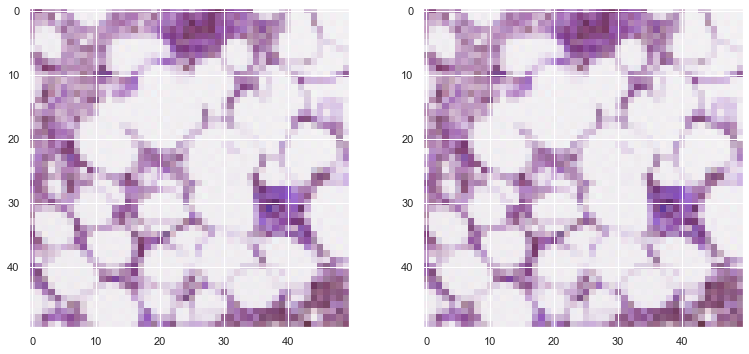

In [40]:
#example for one picture:
img_for_aug2 = preprocess_patch(imagePath_for_Aug, color_mode='RGB')
augmented_img2 = final_augment_patch(img_for_aug2)

plt.figure(1, figsize=(20,20))
n = 1
for img in augmented_img2:
    plt.subplot(3,3,n)
    plt.imshow(img)

    n +=1
    
plt.show()

## Final augmentation to boost the number of patches in the training set with class1

Decision: augment each patch from the smaller class 1 two times and choose as many patches from the newly created patches as we need to have an even distribution among both classes

In [44]:
os.listdir("data/train_class1_augmented/")
filepath = 'data/train_class1_augmented/'

In [45]:
#divide training data by label: 
train_df_class1 = train_df[train_df['label'] == 1] # 55.909
train_df_class0 = train_df[train_df['label'] == 0] # 140.416

In [46]:
train_df_class1

,patient_id,image_path,label,x,y
422,10258,data/breast-histopathology-images/IDC_regular_...,1,801,1101
423,10258,data/breast-histopathology-images/IDC_regular_...,1,1451,1151
424,10258,data/breast-histopathology-images/IDC_regular_...,1,951,751
425,10258,data/breast-histopathology-images/IDC_regular_...,1,1351,1101
426,10258,data/breast-histopathology-images/IDC_regular_...,1,1051,1001
...,...,...,...,...,...
277519,12891,data/breast-histopathology-images/IDC_regular_...,1,501,801
277520,12891,data/breast-histopathology-images/IDC_regular_...,1,551,701
277521,12891,data/breast-histopathology-images/IDC_regular_...,1,601,1051
277522,12891,data/breast-histopathology-images/IDC_regular_...,1,701,951


In [57]:
#create augmented image patches and save them to a new folder (only for class 1 from train_df)
filepath = 'data/train_class1_augmented/'

for index in range(len(train_df_class1)):
    img_path = train_df_class1.iloc[index]['image_path']
    new_filepath = (filepath + str(train_df_class1.iloc[index]['patient_id']) + '_idx5_x' + 
                    str(train_df_class1.iloc[index]['x']) + '_y' + str(train_df_class1.iloc[index]['y']) + 
                    '_class' + str(train_df_class1.iloc[index]['label']) + '_' + str(index))

    prep_img = preprocess_patch(img_path, color_mode='RGB')
    two_aug_imgs = final_augment_patch(prep_img)
    two_aug_imgs[0].save(new_filepath + 'a.png')
    two_aug_imgs[1].save(new_filepath + 'b.png')
    #augmented_train_class1.extend(two_aug_imgs)


### Load newly created augmented patches; final train_df creation

In [47]:
allAugPatches = glob(filepath + '/*.png', recursive=True)
nrAugPatches = len(allAugPatches)
nrAugPatches

111818

In [48]:
#create dataframe:
all_images = listdir(filepath)
aug_data = pd.DataFrame(all_images, columns=['image_name'])

aug_data

,image_name
0,12891_idx5_x1501_y1301_class1_55770b.png
1,16166_idx5_x1401_y1051_class1_10425a.png
2,9083_idx5_x1701_y701_class1_122b.png
3,10308_idx5_x1451_y1751_class1_2715b.png
4,9226_idx5_x1251_y2151_class1_49264b.png
...,...
111813,12818_idx5_x2401_y1301_class1_35397b.png
111814,8956_idx5_x1001_y301_class1_17554a.png
111815,14189_idx5_x1951_y1701_class1_15500a.png
111816,13693_idx5_x851_y1851_class1_38101b.png


In [49]:
#create new columns for the dataframe:

def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    # the id is the first index in the list
    patient_id = a[0]
    
    return patient_id

def extract_target(x):
    # split into a list
    a = x.split('_')
    # the target is part of the string in index 4
    b = a[4]
    # the ytarget i.e. 1 or 2 is the 5th index of the string --> class1
    target = b[5]
    
    return target

def create_image_path(x):
    return filepath + x

# create a new column called 'patient_id'
aug_data['patient_id'] = aug_data['image_name'].apply(extract_patient_id)
#create a new column called 'image_path'
aug_data['image_path'] = aug_data['image_name'].apply(create_image_path)
# create a new column called 'target'
aug_data['label'] = aug_data['image_name'].apply(extract_target)

#drop column 'image_name'
aug_data = aug_data.drop(['image_name'], axis=1)

In [50]:
aug_data

,patient_id,image_path,label
0,12891,data/train_class1_augmented/12891_idx5_x1501_y...,1
1,16166,data/train_class1_augmented/16166_idx5_x1401_y...,1
2,9083,data/train_class1_augmented/9083_idx5_x1701_y7...,1
3,10308,data/train_class1_augmented/10308_idx5_x1451_y...,1
4,9226,data/train_class1_augmented/9226_idx5_x1251_y2...,1
...,...,...,...
111813,12818,data/train_class1_augmented/12818_idx5_x2401_y...,1
111814,8956,data/train_class1_augmented/8956_idx5_x1001_y3...,1
111815,14189,data/train_class1_augmented/14189_idx5_x1951_y...,1
111816,13693,data/train_class1_augmented/13693_idx5_x851_y1...,1


In [51]:
#extract coords for augmented_dataframe:
def extract_coords_for_aug_data(df):
    coord = df.image_path.str.rsplit("_", n=5, expand=True)
    coord = coord.drop([0, 1, 4, 5], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(np.int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(np.int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

In [52]:
#all augmented data (all class 1):
aug_data_with_coords = extract_coords_for_aug_data(aug_data)
nr_augmented_data = len(aug_data_with_coords)

len_train_class0 = len(train_df_class0)
len_train_class1 = len(train_df_class1)

nr_missing_patches_for_class1 = len_train_class0 - len_train_class1

print("Number of newly augmented data from train set (class 1 only): " + str(nr_augmented_data))
print("Original number of patches in class 1: " + str(len_train_class1))
print("Wanted number for each class in training set: " + str(len_train_class0))
print("Nr of patches we will take from augmented data to fill up class 1: " + str(nr_missing_patches_for_class1))

Number of newly augmented data from train set (class 1 only): 111818
Original number of patches in class 1: 55909
Wanted number for each class in training set: 140416
Nr of patches we will take from augmented data to fill up class 1: 84507


In [53]:
#take number patches from aug_data needed to fill up class 1 so it reaches the same size as train patches with class 0:
aug_samples = aug_data_with_coords.sample(n=nr_missing_patches_for_class1)
aug_samples

,patient_id,image_path,label,x,y
94680,8951,data/train_class1_augmented/8951_idx5_x1451_y7...,1,1451,701
21069,8863,data/train_class1_augmented/8863_idx5_x1501_y1...,1,1501,1551
87446,12948,data/train_class1_augmented/12948_idx5_x851_y8...,1,851,851
25089,10299,data/train_class1_augmented/10299_idx5_x1101_y...,1,1101,551
73491,9073,data/train_class1_augmented/9073_idx5_x1201_y8...,1,1201,801
...,...,...,...,...,...
8855,14191,data/train_class1_augmented/14191_idx5_x2251_y...,1,2251,1751
37800,10308,data/train_class1_augmented/10308_idx5_x1451_y...,1,1451,851
26399,12817,data/train_class1_augmented/12817_idx5_x1951_y...,1,1951,601
93803,10285,data/train_class1_augmented/10285_idx5_x1051_y...,1,1051,751


### Now, as we have the samples from the augmented data with class 1 we can add it together with the rest of the data from the training set to get our final training data set:

In [55]:
final_train_df = pd.concat([train_df, aug_samples], ignore_index=True)
train_size = len(final_train_df)
print("The size of our final training data set is: " + str(train_size))

The size of our final training data set is: 280832


### Save final_train_df, val_df and test_df to json:

In [61]:
final_train_df.to_json("dataframes/final_train_df.json")
val_df = extract_coords(val_df)
test_df = extract_coords(test_df)
val_df.to_json("dataframes/val_df.json")
test_df.to_json("dataframes/test_df.json")